In [1]:
# Import Dependencies 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf

import pandas as pd
from matplotlib import pyplot as plt 
import os

In [2]:
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
spark_version = 'spark-3.0.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/graph

In [3]:
# Start a Spark session 
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [5]:

# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://lgodleski-bucket.s3.us-east-2.amazonaws.com/murders_county_merged.csv"
spark.sparkContext.addFile(url)
murders_county_merged_df = spark.read.csv(SparkFiles.get("murders_county_merged.csv"), sep=",", header=True, inferSchema=True)
murders_county_merged_df.show()

+--------+-------+--------+------+------+--------+-----+-----+------+-----+-------+-------+------+---------+------------+---------------+-------+------------+--------+------------+--------+----------+----------------+----+---------+--------+--------------------+-----------+---------+---------+----------+---------------+--------------+--------------+---------------+--------------------+------------+-------+-----------+----------------+
|censusid| county|totalpop|   men| women|hispanic|white|black|native|asian|pacific|citizen|income|incomeerr|incomepercap|incomepercaperr|poverty|childpoverty|employed|unemployment|recordid|agencyname|      agencytype|year|    month|incident|           crimetype|crimesolved|victimsex|victimage|victimrace|victimethnicity|perpetratorsex|perpetratorage|perpetratorrace|perpetratorethnicity|relationship| weapon|victimcount|perpetratorcount|
+--------+-------+--------+------+------+--------+-----+-----+------+-----+-------+-------+------+---------+------------+-

In [6]:
# Convert PySpark DataFrame to Pandas DataFrame
murders_df = murders_county_merged_df.toPandas()

censusid                  int32
county                   object
totalpop                  int32
men                       int32
women                     int32
hispanic                float64
white                   float64
black                   float64
native                  float64
asian                   float64
pacific                 float64
citizen                   int32
income                    int32
incomeerr                 int32
incomepercap              int32
incomepercaperr           int32
poverty                 float64
childpoverty            float64
employed                  int32
unemployment            float64
recordid                  int32
agencyname               object
agencytype               object
year                      int32
month                    object
incident                  int32
crimetype                object
crimesolved              object
victimsex                object
victimage                 int32
victimrace               object
victimet

In [8]:
# Remove unncessary columns 
murders_df.drop(columns=['censusid', 'recordid','incomeerr','incomepercaperr','agencyname','incident'],inplace=True)

In [11]:
# Remove victim age of 99 from dataset (potential outlier; 1049 instances
murders_viz = murders_df.loc[murders_df['victimage'] != 99]

In [14]:
# Export to shared folder for visualizations 
from google.colab import files
murders_viz.to_csv('murders_viz.csv',index=False) 
files.download('murders_viz.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Data Preprocessing 

In [17]:
# Generate our categorical variable list 
murder_cat = murders_viz.dtypes[murders_viz.dtypes == "object"].index.tolist()
murder_cat

['county',
 'agencytype',
 'month',
 'crimetype',
 'crimesolved',
 'victimsex',
 'victimrace',
 'victimethnicity',
 'perpetratorsex',
 'perpetratorrace',
 'perpetratorethnicity',
 'relationship',
 'weapon']

In [18]:
# Determine number of unique values for each cat. column for potential binning 
murders_viz[murder_cat].nunique()

county                  58
agencytype               4
month                   12
crimetype                2
crimesolved              2
victimsex                3
victimrace               5
victimethnicity          3
perpetratorsex           3
perpetratorrace          5
perpetratorethnicity     3
relationship            28
weapon                  15
dtype: int64

In [19]:
# Look at relationship value counts for binning
murders_viz.relationship.value_counts()

Unknown                 44278
Stranger                23692
Acquaintance             9534
Friend                   5935
Wife                     2955
Girlfriend               2327
Son                      1292
Daughter                 1081
Family                   1059
Neighbor                  986
Husband                   804
Boyfriend                 708
Mother                    621
Brother                   601
Father                    521
In-Law                    487
Boyfriend/Girlfriend      405
Common-Law Wife           309
Ex-Wife                   194
Stepfather                169
Common-Law Husband        166
Sister                    146
Employer                  124
Stepson                   119
Stepdaughter               90
Employee                   56
Ex-Husband                 49
Stepmother                 26
Name: relationship, dtype: int64

In [20]:
# Look at weapon value counts for binning 
murders_viz.weapon.value_counts()

Handgun          55052
Knife            14855
Blunt Object     10061
Shotgun           4333
Firearm           4258
Rifle             4077
Unknown           2362
Strangulation     1831
Suffocation        754
Fire               573
Drowning           236
Drugs              178
Poison              76
Explosives          48
Gun                 40
Name: weapon, dtype: int64

In [21]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(murders_viz[murder_cat]))

# Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(murder_cat)
encode_df.head()

,county_Alameda,county_Alpine,county_Amador,county_Butte,county_Calaveras,county_Colusa,county_Contra Costa,county_Del Norte,county_El Dorado,county_Fresno,county_Glenn,county_Humboldt,county_Imperial,county_Inyo,county_Kern,county_Kings,county_Lake,county_Lassen,county_Los Angeles,county_Madera,county_Marin,county_Mariposa,county_Mendocino,county_Merced,county_Modoc,county_Mono,county_Monterey,county_Napa,county_Nevada,county_Orange,county_Placer,county_Plumas,county_Riverside,county_Sacramento,county_San Benito,county_San Bernardino,county_San Diego,county_San Francisco,county_San Joaquin,county_San Luis Obispo,...,relationship_Brother,relationship_Common-Law Husband,relationship_Common-Law Wife,relationship_Daughter,relationship_Employee,relationship_Employer,relationship_Ex-Husband,relationship_Ex-Wife,relationship_Family,relationship_Father,relationship_Friend,relationship_Girlfriend,relationship_Husband,relationship_In-Law,relationship_Mother,relationship_Neighbor,relationship_Sister,relationship_Son,relationship_Stepdaughter,relationship_Stepfather,relationship_Stepmother,relationship_Stepson,relationship_Stranger,relationship_Unknown,relationship_Wife,weapon_Blunt Object,weapon_Drowning,weapon_Drugs,weapon_Explosives,weapon_Fire,weapon_Firearm,weapon_Gun,weapon_Handgun,weapon_Knife,weapon_Poison,weapon_Rifle,weapon_Shotgun,weapon_Strangulation,weapon_Suffocation,weapon_Unknown
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Merge one-hot encoded features and drop the originals
murders_viz = murders_viz.merge(encode_df,left_index=True, right_index=True)
murders_viz = murders_viz.drop(murder_cat,1)
murders_viz.head()

,totalpop,men,women,hispanic,white,black,native,asian,pacific,citizen,income,incomepercap,poverty,childpoverty,employed,unemployment,year,victimage,perpetratorage,victimcount,perpetratorcount,county_Alameda,county_Alpine,county_Amador,county_Butte,county_Calaveras,county_Colusa,county_Contra Costa,county_Del Norte,county_El Dorado,county_Fresno,county_Glenn,county_Humboldt,county_Imperial,county_Inyo,county_Kern,county_Kings,county_Lake,county_Lassen,county_Los Angeles,...,relationship_Brother,relationship_Common-Law Husband,relationship_Common-Law Wife,relationship_Daughter,relationship_Employee,relationship_Employer,relationship_Ex-Husband,relationship_Ex-Wife,relationship_Family,relationship_Father,relationship_Friend,relationship_Girlfriend,relationship_Husband,relationship_In-Law,relationship_Mother,relationship_Neighbor,relationship_Sister,relationship_Son,relationship_Stepdaughter,relationship_Stepfather,relationship_Stepmother,relationship_Stepson,relationship_Stranger,relationship_Unknown,relationship_Wife,weapon_Blunt Object,weapon_Drowning,weapon_Drugs,weapon_Explosives,weapon_Fire,weapon_Firearm,weapon_Gun,weapon_Handgun,weapon_Knife,weapon_Poison,weapon_Rifle,weapon_Shotgun,weapon_Strangulation,weapon_Suffocation,weapon_Unknown
0,1584983,776699,808284,22.6,33.0,11.3,0.3,27.5,0.8,1025865,75619,37285,12.5,15.2,778132,8.3,1980,21,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1584983,776699,808284,22.6,33.0,11.3,0.3,27.5,0.8,1025865,75619,37285,12.5,15.2,778132,8.3,1980,17,39,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1584983,776699,808284,22.6,33.0,11.3,0.3,27.5,0.8,1025865,75619,37285,12.5,15.2,778132,8.3,1980,56,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1584983,776699,808284,22.6,33.0,11.3,0.3,27.5,0.8,1025865,75619,37285,12.5,15.2,778132,8.3,1980,43,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1584983,776699,808284,22.6,33.0,11.3,0.3,27.5,0.8,1025865,75619,37285,12.5,15.2,778132,8.3,1980,31,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
murders_viz.crimesolved

Index(['totalpop', 'men', 'women', 'hispanic', 'white', 'black', 'native',
       'asian', 'pacific', 'citizen',
       ...
       'weapon_Firearm', 'weapon_Gun', 'weapon_Handgun', 'weapon_Knife',
       'weapon_Poison', 'weapon_Rifle', 'weapon_Shotgun',
       'weapon_Strangulation', 'weapon_Suffocation', 'weapon_Unknown'],
      dtype='object', length=164)

In [25]:
# Remove 'crimesolved_No and crimesolved_Yes' target from features data
y = murders_viz["crimesolved_Yes"].values
X = murders_viz.drop(['crimesolved_Yes','crimesolved_No'],1).values

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=89, stratify=y)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Random Forest Model 

In [26]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=500, random_state=89)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f'Random forest training score: {rf_model.score(X_train_scaled, y_train)}')
print(f'Random forest testing score: {rf_model.score(X_test_scaled, y_test)}')
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

Random forest training score: 1.0
Random forest testing score: 1.0
 Random forest predictive accuracy: 1.000


[1.25183554e-04 1.34115100e-04 1.27172906e-04 1.05997632e-04
 1.10137070e-04 7.28261455e-05 5.22775511e-05 7.77748604e-05
 9.69769692e-05 1.39628145e-04 7.50115323e-05 8.43975551e-05
 6.80275942e-05 7.80605311e-05 1.40306227e-04 6.33891657e-05
 2.76039242e-03 2.60752464e-04 2.09619289e-04 4.17933179e-05
 7.68995567e-05 8.04146026e-05 0.00000000e+00 6.18813540e-07
 4.09617073e-06 6.58974896e-07 8.93066989e-08 1.29895250e-05
 4.07621160e-07 3.22472490e-06 1.35733950e-05 3.25381735e-07
 5.68720269e-06 2.40773164e-06 2.22732691e-06 1.30329916e-05
 4.77356898e-07 1.82463746e-06 2.84028712e-06 2.82408470e-04
 3.84114826e-06 2.25412693e-06 1.50549210e-06 5.14524256e-06
 4.81922594e-06 5.36800403e-07 0.00000000e+00 8.81622863e-06
 8.84032033e-07 7.06471547e-07 3.91641457e-05 3.24185185e-06
 2.12337516e-07 1.52637475e-05 3.51620849e-05 5.77405935e-06
 2.01149739e-05 2.54131844e-05 6.38788832e-05 1.09122959e-05
 1.07453013e-06 9.01355587e-06 1.07524097e-05 2.83771811e-05
 6.65831420e-06 4.820326

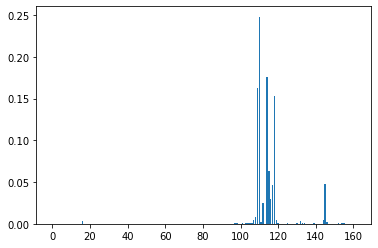

In [27]:
# Rank features by importance and plot 
features = rf_model.feature_importances_
print(features)
plt.bar(x = range(len(features)), height=features)
plt.show()

##Logistic Regression Model

In [29]:
# Import LogisticRegression 
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model.
logr_model = LogisticRegression()

# Fitting the model. 
logr_model.fit(X_train_scaled, y_train)

# Evaluate the model. 
print(f'Logistic regression training Score: {logr_model.score(X_train_scaled, y_train)}')
print(f'Logistic regression testing Score: {logr_model.score(X_test_scaled, y_test)}')
print(f" Logistic regression predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

Logistic regression training Score: 1.0
Logistic regression testing Score: 1.0
 Logistic regression predictive accuracy: 1.000


## Deep Neural Net Model 

In [31]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
# Change number of nodes to reflect this dataset: layer1 + layer 2 should equal # of columns after merge/drop OneHotEncoding 
hidden_nodes_layer1 =  24
hidden_nodes_layer2 = 12

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))


# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=50)

# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Epoch 1/50
2290/2290 [==============================] - 4s 2ms/step - loss: 0.0217 - accuracy: 0.9934
Epoch 2/50
2290/2290 [==============================] - 4s 2ms/step - loss: 3.6682e-04 - accuracy: 0.9999
Epoch 3/50
2290/2290 [==============================] - 4s 2ms/step - loss: 1.8016e-04 - accuracy: 1.0000
Epoch 4/50
2290/2290 [==============================] - 4s 2ms/step - loss: 4.1696e-05 - accuracy: 1.0000
Epoch 5/50
2290/2290 [==============================] - 4s 2ms/step - loss: 3.3082e-06 - accuracy: 1.0000
Epoch 6/50
2290/2290 [==============================] - 4s 2ms/step - loss: 5.9802e-06 - accuracy: 1.0000
Epoch 7/50
2290/2290 [==============================] - 4s 2ms/step - loss: 2.8982e-05 - accuracy: 1.0000
Epoch 8/50
2290/2290 [==============================] - 4s 2ms/step - loss: 1.7749e-06 - accuracy: 1.0000
Epoch 9/50
2290/2290 [==============================] - 4s 2ms/step - loss: 1.5868e-07 - accuracy: 1.0000
Epoch 10/50
2290/2290 [===========================

AttributeError: ignored